In [1]:
#!pip install cupy-cuda101
!pip install cupy-cuda101==8.0.0rc1 --upgrade
#!pip install cupy
#!pip install pylops[advanced]
!pip install git+https://github.com/mrava87/pylops@cupy-ext

     |████████████████████████████████| 114.9MB 92kB/s 
  Found existing installation: cupy-cuda101 7.4.0
    Uninstalling cupy-cuda101-7.4.0:
      Successfully uninstalled cupy-cuda101-7.4.0
  Cloning https://github.com/mrava87/pylops (to revision cupy-ext) to /tmp/pip-req-build-m8ci1enl
  Running command git clone -q https://github.com/mrava87/pylops /tmp/pip-req-build-m8ci1enl
  Running command git checkout -b cupy-ext --track origin/cupy-ext
  Switched to a new branch 'cupy-ext'
  Branch 'cupy-ext' set up to track remote branch 'cupy-ext' from 'origin'.
  Created wheel for pylops: filename=pylops-1.10.1.dev97+gf16b5d2-cp36-none-any.whl size=163221 sha256=aa7de829dda6ccf6e6053e5a2929c2204778caf82b5af7c15e576aed800331f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-fn6v9wal/wheels/ee/c6/91/602ea68e6c612f7b41703971525d62bc6270318ac1e29433fa
Successfully built pylops


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

## Data reconstruction:  RegularizedInversion,  NormalEquationsInversion, ISTA , FISTA

Dot test passed, v^T(Opu)=8.572170 - u^T(Op^Tv)=8.572170


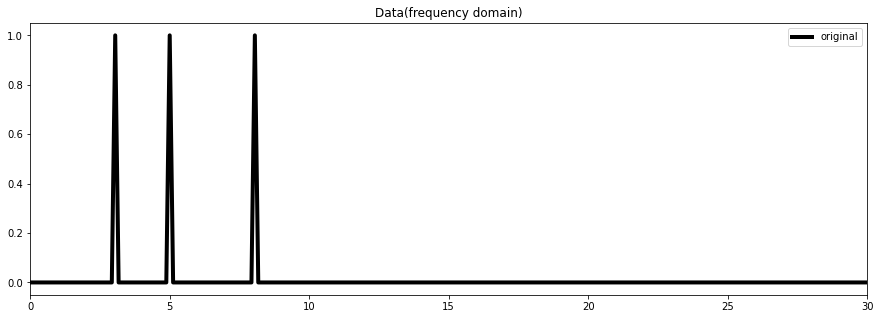

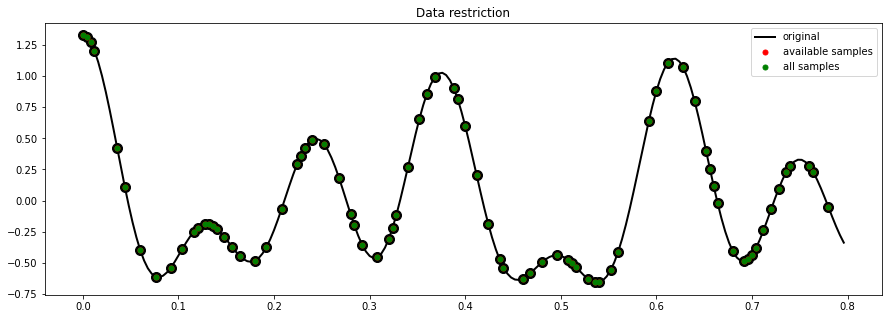

In [3]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = cp.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(cp.asnumpy(X)), 'k', LineWidth=4,   label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N, verb=True, backend='cupy')

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),       'k' , LineWidth=2,   label='original')
plt.plot(t[iava], cp.asnumpy(x)[iava], '.k', MarkerSize=20)
plt.plot(t[iava], cp.asnumpy(y),       '.r', MarkerSize=10, label='available samples')
plt.plot(t,       ymask,   '.g', MarkerSize=10, label='all samples')
plt.legend()
plt.title('Data restriction');

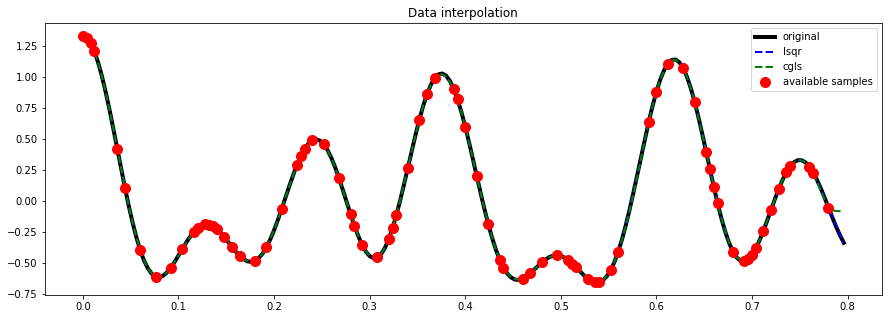

In [4]:
# Create regularization operator
D2op  = SecondDerivative(N, dims=None, dtype='float64')

# Invert for interpolated signal
xlsqr_reg_lop, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], cp.asnumpy(y), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200, show=0))

xcgls_reg_lop = \
    RegularizedInversion(Rop, [D2op], y, epsRs=[np.sqrt(0.5)], returninfo=False,
                         **dict(damp=np.sqrt(1e-4), niter=200, show=0))

fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),              'k'   , LineWidth=4,   label='original')
plt.plot(t,       cp.asnumpy(xlsqr_reg_lop), '--b' , LineWidth=2,   label='lsqr')
plt.plot(t,       cp.asnumpy(xcgls_reg_lop), '--g' , LineWidth=2,   label='cgls')
plt.plot(t[iava], cp.asnumpy(y),              '.r'  , MarkerSize=20, label='available samples')
plt.legend()
plt.title('Data interpolation');

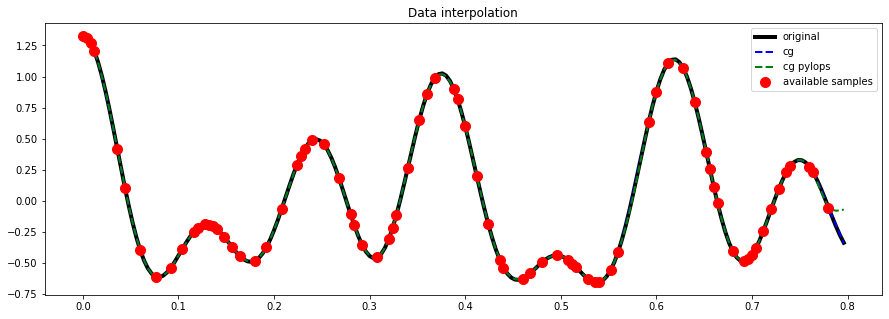

In [5]:
epsR=np.sqrt(0.1)
epsI=np.sqrt(1e-4)
x_cg_lop, istop = NormalEquationsInversion(Rop, [D2op], cp.asnumpy(y), epsI=epsI, epsRs=[epsR], returninfo=True, 
                                           **dict(maxiter=200))
epsR=np.sqrt(0.4)
epsI=np.sqrt(1e-4)
x_cgls_lop, istop = NormalEquationsInversion(Rop, [D2op], y, epsI=epsI, epsRs=[epsR], returninfo=True, 
                                             **dict(niter=200))

fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),              'k'   , LineWidth=4,   label='original')
plt.plot(t,       x_cg_lop, '--b' , LineWidth=2,   label='cg')
plt.plot(t,       cp.asnumpy(x_cgls_lop), '--g' , LineWidth=2,   label='cg pylops')
plt.plot(t[iava], cp.asnumpy(y),              '.r'  , MarkerSize=20, label='available samples')
plt.legend()
plt.title('Data interpolation');

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


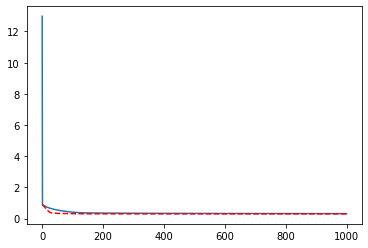

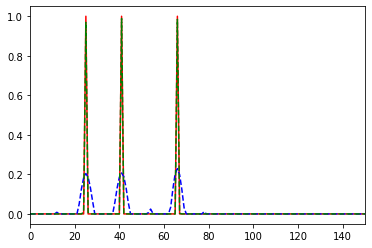

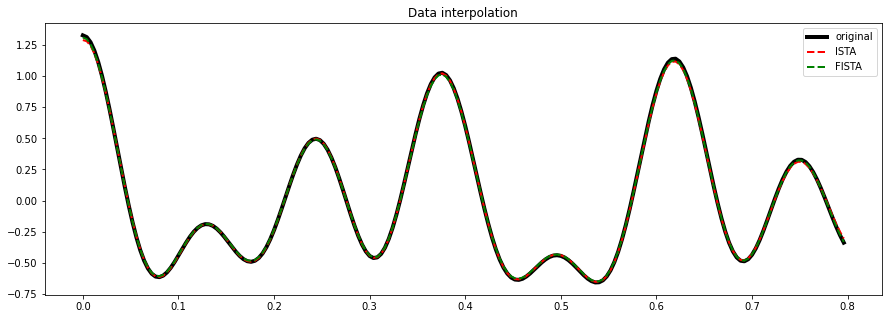

In [6]:
Xinv, niter, cost = ISTA(Rop*FFTop.H, y, niter=1000, eps=0.1, tol=1e-8, eigsiter=10, monitorres=False, 
                         returninfo=True, show=False)
xinv = FFTop.H*Xinv

Xinv1, niter1, cost1 = FISTA(Rop*FFTop.H, y, niter=1000, eps=0.1, tol=1e-8, eigsiter=10, returninfo=True, show=False)
xinv1 = FFTop.H*Xinv1

plt.figure()
plt.plot(cost)
plt.plot(cost1, '--r')

plt.figure()
plt.plot(cp.asnumpy(X), 'r')
plt.plot(cp.asnumpy(Xinv), '--b')
plt.plot(cp.asnumpy(Xinv1), '--g')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t, cp.asnumpy(x), 'k', LineWidth=4,   label='original')
plt.plot(t, cp.asnumpy(xinv), '--r' , LineWidth=2, label='ISTA')
plt.plot(t, cp.asnumpy(xinv1), '--g' , LineWidth=2, label='FISTA')
plt.legend()
plt.title('Data interpolation');

## IRLS model

In [7]:
nx = 100
nnz = 5
ny = 20

x = cp.zeros(nx)
inz = np.random.permutation(np.arange(nx))[:nnz]
x[inz] = cp.random.uniform(0, 10, nnz)

A = MatrixMult(cp.random.normal(0, 1, (ny, nx)))
y = A @ x

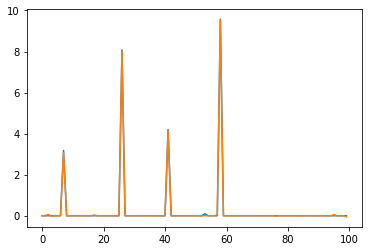

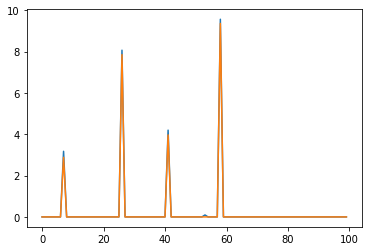

In [8]:
xinv = IRLS(A, y, 20, epsI=0, kind='model', **dict(niter=10))[0]
plt.figure()
plt.plot(cp.asnumpy(x))
plt.plot(cp.asnumpy(xinv))

xinv = FISTA(A, y, 100, eps=10.)[0]
plt.figure()
plt.plot(cp.asnumpy(x))
plt.plot(cp.asnumpy(xinv))

## ILRS data

IRLS converged at 6 iterations...


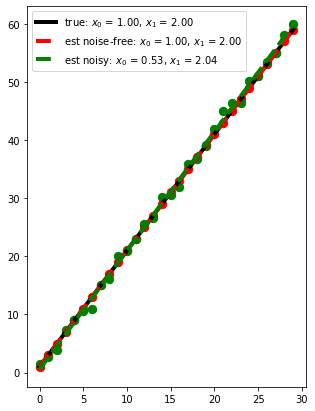

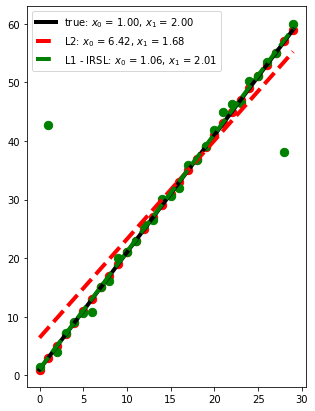

In [9]:
np.random.seed(10)

N = 30
x = cp.array([1., 2.])
sigma = 1

t = cp.arange(N, dtype='float64')
LRop = LinearRegression(t, dtype='float64')

y = LRop * x
yn = y + cp.random.normal(0, sigma, N)

xest = LRop / y
xnest = LRop / yn

plt.figure(figsize=(5, 7))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(x[1]) + cp.asnumpy(x[0]), 'k', lw=4,
         label=r'true: $x_0$ = %.2f, $x_1$ = %.2f' % (x[0], x[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xest[1]) + cp.asnumpy(xest[0]), '--r', lw=4,
         label=r'est noise-free: $x_0$ = %.2f, $x_1$ = %.2f'
         %(xest[0], xest[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xnest[1]) + cp.asnumpy(xnest[0]), '--g', lw=4,
         label=r'est noisy: $x_0$ = %.2f, $x_1$ = %.2f'
         %(xnest[0], xnest[1]))
plt.scatter(cp.asnumpy(t), cp.asnumpy(y), c='r', s=70)
plt.scatter(cp.asnumpy(t), cp.asnumpy(yn), c='g', s=70)
plt.legend()

# Add outliers
yn[1] += 40
yn[N-2] -= 20

# IRLS
nouter = 20
epsR = 5e-3
epsI = 0
tolIRLS = 1e-2

xnest = LRop / yn
xirls, nouter, xirls_hist, rw_hist = \
  IRLS(LRop, yn, nouter, threshR=False,
       epsR=epsR, epsI=epsI,
       tolIRLS=tolIRLS, returnhistory=True)
print('IRLS converged at %d iterations...' % nouter)

plt.figure(figsize=(5, 7))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(x[1]) + cp.asnumpy(x[0]), 'k', lw=4,
         label=r'true: $x_0$ = %.2f, $x_1$ = %.2f' % (x[0], x[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xnest[1]) + cp.asnumpy(xnest[0]), '--r', lw=4,
         label=r'L2: $x_0$ = %.2f, $x_1$ = %.2f' %
         (xnest[0], xnest[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xirls[1]) + cp.asnumpy(xirls[0]), '--g', lw=4,
         label=r'L1 - IRSL: $x_0$ = %.2f, $x_1$ = %.2f' %
         (xirls[0], xirls[1]))
plt.scatter(cp.asnumpy(t), cp.asnumpy(y), c='r', s=70)
plt.scatter(cp.asnumpy(t), cp.asnumpy(yn), c='g', s=70)
plt.legend()

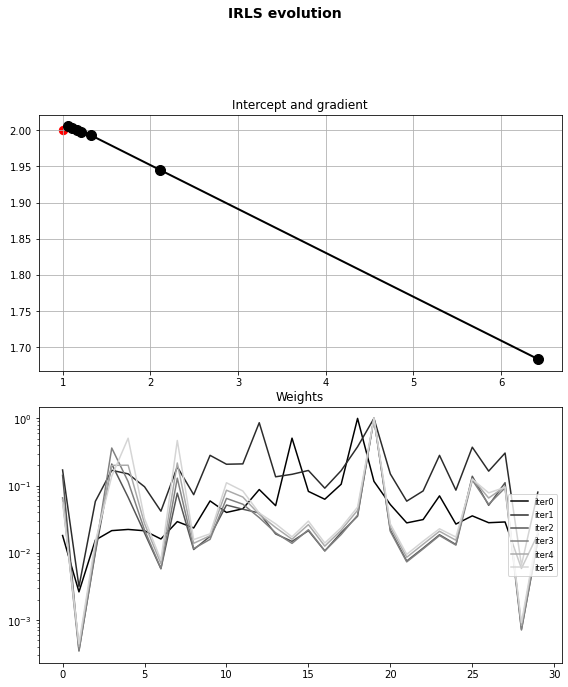

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
fig.suptitle('IRLS evolution', fontsize=14,
             fontweight='bold', y=0.95)
axs[0].plot(cp.asnumpy(xirls_hist[:, 0]), cp.asnumpy(xirls_hist[:, 1]), '.-k', lw=2, ms=20)
axs[0].scatter(cp.asnumpy(x[0]), cp.asnumpy(x[1]), c='r', s=70)
axs[0].set_title('Intercept and gradient')
axs[0].grid()
for iiter in range(nouter):
    axs[1].semilogy(cp.asnumpy(rw_hist[iiter]),
                    color=(iiter/nouter, iiter/nouter, iiter/nouter),
                    label='iter%d' %iiter)
axs[1].set_title('Weights')
axs[1].legend(loc=5, fontsize='small')
plt.tight_layout()
plt.subplots_adjust(top=0.8)